In [1]:
import os, pickle, time, itertools, re, random, subprocess, joblib, pprint
from io import StringIO
from os.path import exists
from collections import OrderedDict
from tabulate import tabulate

import helpers

import numpy as np
from numpy.random import seed

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from matplotlib import pyplot as plt
%matplotlib inline 

# data pipelines/scaling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import mean_squared_error

# Algorithms
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
import xgboost as xgb

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# explainability
import shap

# Deep Learning stuffz
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt

# ART attack algorithms
from art.estimators.classification import KerasClassifier
from art.estimators.classification import LightGBMClassifier
from art.estimators.classification import XGBoostClassifier
from art.estimators.classification.scikitlearn import SklearnClassifier
from art.attacks.evasion import HopSkipJump
from art.attacks.evasion import FastGradientMethod

# ignore some specific annoying warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# fix up some numpy disply options
np.set_printoptions(suppress=True)

PyTorch not found. Not importing DeepZ functionality


In [2]:
# fixate the random state for reproducability
RANDOM_STATE = 1337
seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Load Target Models

In [32]:
# the tuned Logisitic Regression model
lr_target_model = pickle.load(open('../models/tuned_ridge.bin', 'rb'))


# the tuned LightGBMClassifier
lgbm_target_model = pickle.load(open('../models/tuned_lgbm.bin', 'rb'))


# the target Neural Network
layers  = 4
neurons = 192
dropout = 0.5

nn_target_model = Sequential()
nn_target_model.add(Dense(neurons, input_dim=446, activation='relu'))
nn_target_model.add(Dropout(dropout))
    
for i in range(layers-1):
    nn_target_model.add(Dense(neurons, activation='relu'))
    nn_target_model.add(Dropout(dropout))

nn_target_model.add(Dense(1, activation='sigmoid'))
nn_target_model.load_weights(f"../models/neural_network/tuned_{layers}_{neurons}_{dropout}.ckpt")

nn_scaler = pickle.load(open('../models/nn_scaler.bin', 'rb'))

Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LogisticRegression from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator Pipeline from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.


# Data Preparation

In [4]:
# read in the labeled black box data set
df = pd.read_csv('../datasets/BlackBoxData.ast.csv')

y = df.Label
X = df.drop( ['Path', 'Label'], axis=1)

# the features we're using that were selected by Boruta-Shap
boruta_shap_accepted_features = ['AstCmdletMetrics_CharacterDistribution_&_26_Percent', 'AstMemberArgumentMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_m_6d_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_{_7b_Count', 'AstGroupedBinaryExpressionOperators_Plus_Count', 'AstGroupedAstTypes_StatementBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_UpperAlphaPercent_Average', 'LineByLineMetrics_CharacterDistribution_(_28_Percent', 'LineByLineMetrics_CharacterDistribution_A_41_Percent', 'AstGroupedBinaryExpressionOperators_Format_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_Length_Median', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstCmdletMetrics_UpperAlphaPercent_Mode', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Count', 'AstVariableNameMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_R_52_Count', 'AstCmdletMetrics_CharacterDistribution_n_6e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Count', 'AstTypeExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Percent', 'AstCmdletMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_CharacterDistribution_n_6e_Percent', 'AstGroupedAstTypes_TypeConstraintAst_Count', 'AstStringMetrics_Entropy_Average', 'AstCmdletMetrics_CharacterDistribution_u_75_Percent', 'AstVariableNameMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_d_64_Percent', 'AstStringMetrics_Length_Average', 'AstVariableNameMetrics_CharacterDistribution_1_31_Percent', 'AstCmdletMetrics_CharacterDistribution_j_6a_Count', 'AstCmdletMetrics_CharacterDistribution_u_75_Count', 'AstGroupedBinaryExpressionOperators_Format_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Average', 'LineByLineMetrics_Length_Mode', 'AstMemberMetrics_Entropy_Maximum', 'LineByLineMetrics_CharacterDistribution_#_23_Percent', 'LineByLineMetrics_CharacterDistribution_e_65_Percent', 'AstCmdletMetrics_CharacterDistribution_-_2d_Count', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_E_45_Percent', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Average', 'AstMemberArgumentMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Percent', 'AstGroupedAstTypes_AttributeAst_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Count', 'LineByLineMetrics_CharacterDistribution_Y_59_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Count', 'AstMemberMetrics_CharacterDistribution_{_7b_Count', 'AstCmdletMetrics_CharacterDistribution_`_60_Count', 'AstVariableNameMetrics_CharacterDistribution_`_60_Percent', 'LineByLineMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberMetrics_CharacterDistribution_(_28_Percent', 'AstStringMetrics_Length_Median', 'AstCmdletMetrics_CharacterDistribution_o_6f_Count', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Count', 'AstMemberMetrics_Entropy_Median', 'AstMemberArgumentMetrics_UpperAlphaPercent_Mode', 'AstInvocationOperatorInvokedObjectMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Minimum', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstMemberMetrics_CharacterDistribution_}_7d_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_x_78_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Mode', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Count", 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Count', 'AstStringMetrics_CharacterDistribution_Q_51_Count', "LineByLineMetrics_CharacterDistribution_'_27_Percent", 'AstArrayElementMetrics_UpperAlphaPercent_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_Length_Total', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Maximum', 'AstTypeExpressionMetrics_CharacterDistribution_B_42_Percent', 'AstGroupedAstTypes_IfStatementAst_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Count', 'AstCmdletMetrics_CharacterDistribution_._2e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Mode', 'AstConvertExpressionMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_i_69_Percent', 'AstVariableNameMetrics_Entropy_Range', "AstArrayElementMetrics_CharacterDistribution_'_27_Count", 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Count', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Count', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstCommentMetrics_Entropy_Average', 'AstStringMetrics_CharacterDistribution_Q_51_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Count', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_Entropy_Maximum', 'AstVariableNameMetrics_CharacterDistribution_m_6d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Count', 'AstVariableNameMetrics_Entropy_Average', 'AstGroupedAstTypes_StringConstantExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution__22_Count"', 'AstCmdletMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberArgumentMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Entropy_Average', 'AstCmdletMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_Length_Total', 'AstTypeConstraintMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Mode', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Count', 'LineByLineMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Count', 'LineByLineMetrics_CharacterDistribution_w_77_Percent', 'LineByLineMetrics_CharacterDistribution_V_56_Percent', 'LineByLineMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Count', 'AstMemberArgumentMetrics_CharacterDistribution_E_45_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Count', 'AstCmdletMetrics_Entropy_Mode', 'AstTypeConstraintMetrics_CharacterDistribution_R_52_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Percent', 'AstMemberMetrics_CharacterDistribution_`_60_Count', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstStringMetrics_Length_Mode', 'AstStringMetrics_Density_Average', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Count', 'AstMemberArgumentMetrics_Entropy_Maximum', 'AstMemberMetrics_CharacterDistribution_{_7b_Percent', 'AstGroupedAstTypes_ParameterAst_Percent', 'AstCmdletMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_E_45_Count', 'AstTypeConstraintMetrics_Count', 'AstCommentMetrics_Density_Median', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Percent', 'AstGroupedAstTypes_ArrayLiteralAst_Percent', 'LineByLineMetrics_CharacterDistribution_h_68_Percent', 'AstMemberArgumentMetrics_Entropy_Average', 'AstFunctionNameMetrics_UpperAlphaPercent_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Count', 'LineByLineMetrics_CharacterDistribution_,_2c_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Count', 'AstFunctionNameMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_[_5b_Count', 'AstStringMetrics_CharacterDistribution_Z_5a_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Percent', 'AstCmdletMetrics_CharacterDistribution_e_65_Count', 'AstCmdletMetrics_UpperAlphaPercent_Minimum', 'LineByLineMetrics_Entropy_Median', 'AstTypeConstraintMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Percent', 'AstConvertExpressionMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_[_5b_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Percent', 'LineByLineMetrics_Count', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Count', 'AstConvertExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Count', 'AstVariableNameMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution__22_Percent"', 'AstCmdletMetrics_Length_Minimum', 'LineByLineMetrics_Density_Maximum', 'AstCmdletMetrics_Length_Median', 'AstStringMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_AttributeAst_Count', 'LineByLineMetrics_CharacterDistribution_$_24_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Count', 'AstStringMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_CommandAst_Percent', 'AstCmdletMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution_u_75_Percent', 'AstCmdletMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Percent', 'AstCommentMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_r_72_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Count', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Count', 'AstMemberMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Count', 'AstStringMetrics_Entropy_Minimum', 'AstCmdletMetrics_UpperAlphaPercent_Median', 'AstStringMetrics_CharacterDistribution_}_7d_Count', 'AstMemberMetrics_CharacterDistribution_4_34_Count', 'AstArrayElementMetrics_CharacterDistribution_A_41_Count', 'AstTypeConstraintMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_e_65_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Count', 'AstGroupedAstTypes_PipelineAst_Percent', 'AstCommentMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_CharacterDistribution_G_47_Percent', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Percent', 'AstGroupedAstTypes_VariableExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Count', 'AstVariableNameMetrics_Length_Median', "AstArrayElementMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Range', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Percent', 'LineByLineMetrics_CharacterDistribution_Y_59_Percent', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstVariableNameMetrics_CharacterDistribution_s_73_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Count', 'LineByLineMetrics_Length_Average', 'AstStringMetrics_CharacterDistribution_1_31_Count', 'AstCmdletMetrics_Entropy_Median', 'AstMemberMetrics_CharacterDistribution_t_74_Percent', "LineByLineMetrics_CharacterDistribution_'_27_Count", 'AstGroupedAstTypes_ParameterAst_Count', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Minimum', 'AstMemberMetrics_CharacterDistribution_`_60_Percent', 'AstVariableNameMetrics_CharacterDistribution_t_74_Percent', 'AstMemberMetrics_CharacterDistribution__22_Percent"', 'AstFunctionNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_Entropy_Average', 'AstGroupedAstTypes_NamedBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_\\_5c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_J_4a_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_,_2c_Percent', 'AstVariableNameMetrics_CharacterDistribution_e_65_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Count', 'AstStringMetrics_Entropy_Median', 'AstVariableNameMetrics_CharacterDistribution_a_61_Percent', 'AstStringMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Percent', 'AstCmdletMetrics_CharacterDistribution_T_54_Percent', 'AstCmdletMetrics_CharacterDistribution_I_49_Percent', 'AstVariableNameMetrics_CharacterDistribution_E_45_Percent', 'AstCmdletMetrics_UpperAlphaPercent_Maximum', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Median', 'AstFunctionNameMetrics_UpperAlphaPercent_Average', 'AstGroupedAstTypes_BinaryExpressionAst_Count', 'AstGroupedBinaryExpressionOperators_And_Percent', 'LineByLineMetrics_CharacterDistribution_CR_0D_Count', 'LineByLineMetrics_CharacterDistribution_r_72_Percent', 'AstMemberMetrics_UpperAlphaPercent_Average', 'AstTypeConstraintMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_CharacterDistribution_s_73_Count', 'LineByLineMetrics_Entropy_Maximum', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Count", 'AstCommentMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Average', 'AstStringMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Percent', 'AstCmdletMetrics_CharacterDistribution_`_60_Percent', 'AstFunctionNameMetrics_UpperAlphaPercent_Maximum', 'AstTypeConstraintMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_c_63_Percent', 'AstMemberMetrics_UpperAlphaPercent_Minimum', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Percent", 'AstVariableNameMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Median', 'AstMemberArgumentMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_CharacterDistribution_G_47_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_Length_Total', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Count', 'AstGroupedAssignmentStatements_Equals_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Percent', 'AstStringMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_j_6a_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_UpperAlphaPercent_Average', 'AstVariableNameMetrics_CharacterDistribution_s_73_Count', 'AstInvocationOperatorInvokedObjectMetrics_Density_Median', 'AstVariableNameMetrics_CharacterDistribution_i_69_Percent', 'LineByLineMetrics_CharacterDistribution_]_5d_Count', 'AstTypeExpressionMetrics_CharacterDistribution_E_45_Percent', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'LineByLineMetrics_Density_Average', 'AstMemberMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Count', 'AstTypeExpressionMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Median', 'AstCmdletMetrics_CharacterDistribution_c_63_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Count', 'AstCmdletMetrics_CharacterDistribution_r_72_Count', 'AstVariableNameMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_CR_0D_Percent', 'LineByLineMetrics_CharacterDistribution_0_30_Percent', 'AstStringMetrics_CharacterDistribution_0_30_Count', 'AstMemberMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_Q_51_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_R_52_Percent', 'AstMemberMetrics_CharacterDistribution_i_69_Percent', 'AstIntegerAndDoubleMetrics_CharacterDistribution_9_39_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_4_34_Percent', 'LineByLineMetrics_Length_Total', 'AstCmdletMetrics_Entropy_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_CharacterDistribution_}_7d_Percent', 'AstVariableNameMetrics_CharacterDistribution_a_61_Count', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Percent', 'LineByLineMetrics_CharacterDistribution_4_34_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Percent', 'AstCmdletMetrics_CharacterDistribution_n_6e_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Count', 'AstTypeConstraintMetrics_CharacterDistribution_g_67_Count', 'AstTypeConstraintMetrics_CharacterDistribution_t_74_Count', 'AstGroupedAstTypes_ScriptBlockAst_Percent', 'AstCommentMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_CharacterDistribution_=_3d_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Percent', 'AstCmdletMetrics_CharacterDistribution_B_42_Percent', 'AstStringMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_|_7c_Percent', 'AstGroupedBinaryExpressionOperators_Ieq_Percent', 'LineByLineMetrics_Entropy_Average', 'AstMemberArgumentMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_{_7b_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Length_Maximum', 'AstCommentMetrics_Entropy_Range', 'AstStringMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_Entropy_Maximum', 'AstGroupedBinaryExpressionOperators_Plus_Percent', 'LineByLineMetrics_CharacterDistribution_1_31_Count', 'AstVariableNameMetrics_CharacterDistribution_{_7b_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_n_6e_Count', 'LineByLineMetrics_CharacterDistribution_6_36_Percent', 'AstVariableNameMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_}_7d_Count', 'LineByLineMetrics_CharacterDistribution_e_65_Count', 'AstCommentMetrics_Density_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_Entropy_Mode', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Percent', 'LineByLineMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_F_46_Count', 'LineByLineMetrics_CharacterDistribution_l_6c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Count', 'AstVariableNameMetrics_CharacterDistribution_t_74_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_g_67_Count', 'AstGroupedAstTypes_BinaryExpressionAst_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Mode', 'AstMemberMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_c_63_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Count', 'LineByLineMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_A_41_Percent', 'AstMemberMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_[_5b_Count', 'LineByLineMetrics_CharacterDistribution_n_6e_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstGroupedAstTypes_CommandExpressionAst_Percent', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'LineByLineMetrics_CharacterDistribution_A_41_Count', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Count', 'AstGroupedAstTypes_VariableExpressionAst_Count', 'AstGroupedAstTypes_CommandParameterAst_Percent', 'AstCommentMetrics_Length_Average', 'LineByLineMetrics_UpperAlphaPercent_Median', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Percent', 'AstGroupedAstTypes_StringConstantExpressionAst_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Percent', 'AstCommentMetrics_Density_Average', 'AstMemberArgumentMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Percent', 'AstVariableNameMetrics_CharacterDistribution_`_60_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Percent', 'AstCmdletMetrics_Length_Range', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Count', 'LineByLineMetrics_CharacterDistribution_1_31_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Count', 'LineByLineMetrics_Length_Range', 'AstStringMetrics_Count', 'AstStringMetrics_Length_Minimum', 'LineByLineMetrics_CharacterDistribution_4_34_Percent', 'AstMemberMetrics_CharacterDistribution_y_79_Percent', 'AstVariableNameMetrics_Length_Average', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Percent', 'AstVariableNameMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_O_4f_Percent', 'AstStringMetrics_CharacterDistribution_1_31_Percent', 'LineByLineMetrics_CharacterDistribution__22_Count"', 'AstFunctionNameMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_CharacterDistribution_\\_5c_Percent', 'AstVariableNameMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Count', 'AstMemberArgumentMetrics_CharacterDistribution_H_48_Count', 'AstStringMetrics_Entropy_Range', 'LineByLineMetrics_CharacterDistribution_]_5d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Average', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Percent', 'AstStringMetrics_Length_Maximum', 'AstCommentMetrics_Density_Range', 'LineByLineMetrics_Density_Median', 'AstStringMetrics_CharacterDistribution_4_34_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Total', 'AstVariableNameMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Count', 'AstTypeConstraintMetrics_CharacterDistribution_S_53_Count', 'AstStringMetrics_CharacterDistribution__22_Percent"', 'AstGroupedAstTypes_ParamBlockAst_Count', 'LineByLineMetrics_CharacterDistribution_E_45_Count', 'AstCommentMetrics_Density_Maximum']
X = X[boruta_shap_accepted_features]
# remove "Json" style named features for some of the boosted algorithms that don't like the feature names
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [5]:
def target_model_predict(model_number, X_data, probabilities = False):
    """
    Wrapper that takes a target model number and returns predictions on the input data X.
    
    If probabilities=True is passed, probability of obfuscated for each input is returned in an array.
    Otherwise 0/1 labels are returned.
    
    Meant to act like a black box API.
    """
    if(model_number == 1):
        if probabilities:
            return lr_target_model.predict_proba(X_data)[:,1]
        else:
            return lr_target_model.predict(X_data)
    elif(model_number == 2):
        try:
            if probabilities:
                return lgbm_target_model.predict_proba(X_data.values)[:,1]
            else:
                return lgbm_target_model.predict(X_data.values)
        except:
            if probabilities:
                return lgbm_target_model.predict_proba(X_data)[:,1]
            else:
                return lgbm_target_model.predict(X_data)
    elif(model_number == 3):
        if probabilities:
            return nn_target_model.predict(nn_scaler.transform(X_data)).reshape(1, -1)[0]
        else:
            return np.array(list(map(lambda x: 0 if x < 0.5 else 1, nn_target_model.predict(nn_scaler.transform(X_data))))).reshape(1, -1)[0]
    else:
        print(f"[X] predict() error with model number {model_number}")
        return None

In [6]:
# label the data split off all the training/test sets for each model

X_train_model1, X_test_model1, y_train_model1, y_test_model1 = train_test_split(X, target_model_predict(1, X), test_size=0.2, random_state=RANDOM_STATE)
# Used in the final section for training regressors to match the classifiers:
X_train_model1_prob, X_test_model1_prob, y_train_model1_prob, y_test_model1_prob = train_test_split(X, target_model_predict(1, X, True), test_size=0.2, random_state=RANDOM_STATE)

X_train_model2, X_test_model2, y_train_model2, y_test_model2 = train_test_split(X, target_model_predict(2, X), test_size=0.2, random_state=RANDOM_STATE)
# Used in the final section for training regressors to match the classifiers:
X_train_model2_prob, X_test_model2_prob, y_train_model2_prob, y_test_model2_prob = train_test_split(X, target_model_predict(2, X, True), test_size=0.2, random_state=RANDOM_STATE)

X_train_model3, X_test_model3, y_train_model3, y_test_model3 = train_test_split(X, target_model_predict(3, X), test_size=0.2, random_state=RANDOM_STATE)
# Used in the final section for training regressors to match the classifiers:
X_train_model3_prob, X_test_model3_prob, y_train_model3_prob, y_test_model3_prob = train_test_split(X, target_model_predict(3, X, True), test_size=0.2, random_state=RANDOM_STATE)

# Helpers

In [7]:
def display_model_results(results):
    # results[name] = [fit_models[name], real_acc, local_adv_acc, target_adv_acc, num_transferred_attacks, target_misclassified_sample_acc]
    print("\n" + tabulate([(name, result[1], result[2], result[3], result[4], result[5]) for name,result in results.items()], headers=["Model", "Local Model Acc (test)", "Local Model Acc (adv)", "Target Model Acc (adv)", "Attacks Transferred to Target", "Attack Transferability"]))
    
def is_model_keras(model):
    return (isinstance(model, KerasClassifier) or isinstance(model, keras.Model))

In [8]:
def local_model_predict(local_model, X_data, probabilities = False):
    """
    Performs predictions for the supplied Keras or scikitlearn model.
    """
    if(is_model_keras(local_model)):
        if probabilities:
            return local_model.predict(X_data).reshape(1, -1)[0]
        else:
            return list(map(lambda x: 0 if x < 0.5 else 1, local_model.predict(X_data)))
    else:
        try:
            return local_model.predict(X_data.values)
        except:
            return local_model.predict(X_data)

    
def get_local_model_accuracy(local_model, X_data, y_data, probabilities = False):
    """
    Returns the accuracy of the supplied model on the X and y data sets.
    """
    if probabilities:
        # if the local model is a regression trained on the target probabilities
        labels = list(map(lambda x: 0 if x < 0.5 else 1, local_model_predict(local_model, X_data, True)))
        y_data_labels = list(map(lambda x: 0 if x < 0.5 else 1, y_data))
        return np.sum(np.equal(labels, y_data_labels)) / len(y_data_labels)
    else:
        return np.sum(np.equal(local_model_predict(local_model, X_data), y_data)) / len(y_data)


def get_target_model_accuracy(target_model_number, X_data, y_data):
    """
    Takes a model number, gets predictions using target_model_predict() and returns the accuracy
    """
    return np.sum(np.equal(target_model_predict(target_model_number, X_data), y_data)) / len(y_data)

def display_lr_features(model, num_normal_features=10, num_obf_features=10, linear_regression=False):
    """
    Displays the top "Normal" and "Obfuscated" contributing coefficients for a
    Logistic or Linear Regression model.
    """
    boruta_shap_accepted_features = ['AstCmdletMetrics_CharacterDistribution_&_26_Percent', 'AstMemberArgumentMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_m_6d_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_{_7b_Count', 'AstGroupedBinaryExpressionOperators_Plus_Count', 'AstGroupedAstTypes_StatementBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_UpperAlphaPercent_Average', 'LineByLineMetrics_CharacterDistribution_(_28_Percent', 'LineByLineMetrics_CharacterDistribution_A_41_Percent', 'AstGroupedBinaryExpressionOperators_Format_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_Length_Median', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstCmdletMetrics_UpperAlphaPercent_Mode', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Count', 'AstVariableNameMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_R_52_Count', 'AstCmdletMetrics_CharacterDistribution_n_6e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Count', 'AstTypeExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Percent', 'AstCmdletMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_CharacterDistribution_n_6e_Percent', 'AstGroupedAstTypes_TypeConstraintAst_Count', 'AstStringMetrics_Entropy_Average', 'AstCmdletMetrics_CharacterDistribution_u_75_Percent', 'AstVariableNameMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_d_64_Percent', 'AstStringMetrics_Length_Average', 'AstVariableNameMetrics_CharacterDistribution_1_31_Percent', 'AstCmdletMetrics_CharacterDistribution_j_6a_Count', 'AstCmdletMetrics_CharacterDistribution_u_75_Count', 'AstGroupedBinaryExpressionOperators_Format_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Average', 'LineByLineMetrics_Length_Mode', 'AstMemberMetrics_Entropy_Maximum', 'LineByLineMetrics_CharacterDistribution_#_23_Percent', 'LineByLineMetrics_CharacterDistribution_e_65_Percent', 'AstCmdletMetrics_CharacterDistribution_-_2d_Count', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_E_45_Percent', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Average', 'AstMemberArgumentMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Percent', 'AstGroupedAstTypes_AttributeAst_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Count', 'LineByLineMetrics_CharacterDistribution_Y_59_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Count', 'AstMemberMetrics_CharacterDistribution_{_7b_Count', 'AstCmdletMetrics_CharacterDistribution_`_60_Count', 'AstVariableNameMetrics_CharacterDistribution_`_60_Percent', 'LineByLineMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberMetrics_CharacterDistribution_(_28_Percent', 'AstStringMetrics_Length_Median', 'AstCmdletMetrics_CharacterDistribution_o_6f_Count', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Count', 'AstMemberMetrics_Entropy_Median', 'AstMemberArgumentMetrics_UpperAlphaPercent_Mode', 'AstInvocationOperatorInvokedObjectMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Minimum', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstMemberMetrics_CharacterDistribution_}_7d_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_x_78_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Mode', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Count", 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Count', 'AstStringMetrics_CharacterDistribution_Q_51_Count', "LineByLineMetrics_CharacterDistribution_'_27_Percent", 'AstArrayElementMetrics_UpperAlphaPercent_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_Length_Total', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Maximum', 'AstTypeExpressionMetrics_CharacterDistribution_B_42_Percent', 'AstGroupedAstTypes_IfStatementAst_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Count', 'AstCmdletMetrics_CharacterDistribution_._2e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Mode', 'AstConvertExpressionMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_i_69_Percent', 'AstVariableNameMetrics_Entropy_Range', "AstArrayElementMetrics_CharacterDistribution_'_27_Count", 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Count', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Count', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstCommentMetrics_Entropy_Average', 'AstStringMetrics_CharacterDistribution_Q_51_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Count', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_Entropy_Maximum', 'AstVariableNameMetrics_CharacterDistribution_m_6d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Count', 'AstVariableNameMetrics_Entropy_Average', 'AstGroupedAstTypes_StringConstantExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution__22_Count"', 'AstCmdletMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberArgumentMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Entropy_Average', 'AstCmdletMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_Length_Total', 'AstTypeConstraintMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Mode', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Count', 'LineByLineMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Count', 'LineByLineMetrics_CharacterDistribution_w_77_Percent', 'LineByLineMetrics_CharacterDistribution_V_56_Percent', 'LineByLineMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Count', 'AstMemberArgumentMetrics_CharacterDistribution_E_45_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Count', 'AstCmdletMetrics_Entropy_Mode', 'AstTypeConstraintMetrics_CharacterDistribution_R_52_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Percent', 'AstMemberMetrics_CharacterDistribution_`_60_Count', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstStringMetrics_Length_Mode', 'AstStringMetrics_Density_Average', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Count', 'AstMemberArgumentMetrics_Entropy_Maximum', 'AstMemberMetrics_CharacterDistribution_{_7b_Percent', 'AstGroupedAstTypes_ParameterAst_Percent', 'AstCmdletMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_E_45_Count', 'AstTypeConstraintMetrics_Count', 'AstCommentMetrics_Density_Median', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Percent', 'AstGroupedAstTypes_ArrayLiteralAst_Percent', 'LineByLineMetrics_CharacterDistribution_h_68_Percent', 'AstMemberArgumentMetrics_Entropy_Average', 'AstFunctionNameMetrics_UpperAlphaPercent_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Count', 'LineByLineMetrics_CharacterDistribution_,_2c_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Count', 'AstFunctionNameMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_[_5b_Count', 'AstStringMetrics_CharacterDistribution_Z_5a_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Percent', 'AstCmdletMetrics_CharacterDistribution_e_65_Count', 'AstCmdletMetrics_UpperAlphaPercent_Minimum', 'LineByLineMetrics_Entropy_Median', 'AstTypeConstraintMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Percent', 'AstConvertExpressionMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_[_5b_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Percent', 'LineByLineMetrics_Count', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Count', 'AstConvertExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Count', 'AstVariableNameMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution__22_Percent"', 'AstCmdletMetrics_Length_Minimum', 'LineByLineMetrics_Density_Maximum', 'AstCmdletMetrics_Length_Median', 'AstStringMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_AttributeAst_Count', 'LineByLineMetrics_CharacterDistribution_$_24_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Count', 'AstStringMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_CommandAst_Percent', 'AstCmdletMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution_u_75_Percent', 'AstCmdletMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Percent', 'AstCommentMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_r_72_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Count', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Count', 'AstMemberMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Count', 'AstStringMetrics_Entropy_Minimum', 'AstCmdletMetrics_UpperAlphaPercent_Median', 'AstStringMetrics_CharacterDistribution_}_7d_Count', 'AstMemberMetrics_CharacterDistribution_4_34_Count', 'AstArrayElementMetrics_CharacterDistribution_A_41_Count', 'AstTypeConstraintMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_e_65_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Count', 'AstGroupedAstTypes_PipelineAst_Percent', 'AstCommentMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_CharacterDistribution_G_47_Percent', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Percent', 'AstGroupedAstTypes_VariableExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Count', 'AstVariableNameMetrics_Length_Median', "AstArrayElementMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Range', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Percent', 'LineByLineMetrics_CharacterDistribution_Y_59_Percent', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstVariableNameMetrics_CharacterDistribution_s_73_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Count', 'LineByLineMetrics_Length_Average', 'AstStringMetrics_CharacterDistribution_1_31_Count', 'AstCmdletMetrics_Entropy_Median', 'AstMemberMetrics_CharacterDistribution_t_74_Percent', "LineByLineMetrics_CharacterDistribution_'_27_Count", 'AstGroupedAstTypes_ParameterAst_Count', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Minimum', 'AstMemberMetrics_CharacterDistribution_`_60_Percent', 'AstVariableNameMetrics_CharacterDistribution_t_74_Percent', 'AstMemberMetrics_CharacterDistribution__22_Percent"', 'AstFunctionNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_Entropy_Average', 'AstGroupedAstTypes_NamedBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_\\_5c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_J_4a_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_,_2c_Percent', 'AstVariableNameMetrics_CharacterDistribution_e_65_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Count', 'AstStringMetrics_Entropy_Median', 'AstVariableNameMetrics_CharacterDistribution_a_61_Percent', 'AstStringMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Percent', 'AstCmdletMetrics_CharacterDistribution_T_54_Percent', 'AstCmdletMetrics_CharacterDistribution_I_49_Percent', 'AstVariableNameMetrics_CharacterDistribution_E_45_Percent', 'AstCmdletMetrics_UpperAlphaPercent_Maximum', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Median', 'AstFunctionNameMetrics_UpperAlphaPercent_Average', 'AstGroupedAstTypes_BinaryExpressionAst_Count', 'AstGroupedBinaryExpressionOperators_And_Percent', 'LineByLineMetrics_CharacterDistribution_CR_0D_Count', 'LineByLineMetrics_CharacterDistribution_r_72_Percent', 'AstMemberMetrics_UpperAlphaPercent_Average', 'AstTypeConstraintMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_CharacterDistribution_s_73_Count', 'LineByLineMetrics_Entropy_Maximum', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Count", 'AstCommentMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Average', 'AstStringMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Percent', 'AstCmdletMetrics_CharacterDistribution_`_60_Percent', 'AstFunctionNameMetrics_UpperAlphaPercent_Maximum', 'AstTypeConstraintMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_c_63_Percent', 'AstMemberMetrics_UpperAlphaPercent_Minimum', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Percent", 'AstVariableNameMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Median', 'AstMemberArgumentMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_CharacterDistribution_G_47_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_Length_Total', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Count', 'AstGroupedAssignmentStatements_Equals_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Percent', 'AstStringMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_j_6a_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_UpperAlphaPercent_Average', 'AstVariableNameMetrics_CharacterDistribution_s_73_Count', 'AstInvocationOperatorInvokedObjectMetrics_Density_Median', 'AstVariableNameMetrics_CharacterDistribution_i_69_Percent', 'LineByLineMetrics_CharacterDistribution_]_5d_Count', 'AstTypeExpressionMetrics_CharacterDistribution_E_45_Percent', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'LineByLineMetrics_Density_Average', 'AstMemberMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Count', 'AstTypeExpressionMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Median', 'AstCmdletMetrics_CharacterDistribution_c_63_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Count', 'AstCmdletMetrics_CharacterDistribution_r_72_Count', 'AstVariableNameMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_CR_0D_Percent', 'LineByLineMetrics_CharacterDistribution_0_30_Percent', 'AstStringMetrics_CharacterDistribution_0_30_Count', 'AstMemberMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_Q_51_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_R_52_Percent', 'AstMemberMetrics_CharacterDistribution_i_69_Percent', 'AstIntegerAndDoubleMetrics_CharacterDistribution_9_39_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_4_34_Percent', 'LineByLineMetrics_Length_Total', 'AstCmdletMetrics_Entropy_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_CharacterDistribution_}_7d_Percent', 'AstVariableNameMetrics_CharacterDistribution_a_61_Count', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Percent', 'LineByLineMetrics_CharacterDistribution_4_34_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Percent', 'AstCmdletMetrics_CharacterDistribution_n_6e_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Count', 'AstTypeConstraintMetrics_CharacterDistribution_g_67_Count', 'AstTypeConstraintMetrics_CharacterDistribution_t_74_Count', 'AstGroupedAstTypes_ScriptBlockAst_Percent', 'AstCommentMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_CharacterDistribution_=_3d_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Percent', 'AstCmdletMetrics_CharacterDistribution_B_42_Percent', 'AstStringMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_|_7c_Percent', 'AstGroupedBinaryExpressionOperators_Ieq_Percent', 'LineByLineMetrics_Entropy_Average', 'AstMemberArgumentMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_{_7b_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Length_Maximum', 'AstCommentMetrics_Entropy_Range', 'AstStringMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_Entropy_Maximum', 'AstGroupedBinaryExpressionOperators_Plus_Percent', 'LineByLineMetrics_CharacterDistribution_1_31_Count', 'AstVariableNameMetrics_CharacterDistribution_{_7b_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_n_6e_Count', 'LineByLineMetrics_CharacterDistribution_6_36_Percent', 'AstVariableNameMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_}_7d_Count', 'LineByLineMetrics_CharacterDistribution_e_65_Count', 'AstCommentMetrics_Density_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_Entropy_Mode', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Percent', 'LineByLineMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_F_46_Count', 'LineByLineMetrics_CharacterDistribution_l_6c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Count', 'AstVariableNameMetrics_CharacterDistribution_t_74_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_g_67_Count', 'AstGroupedAstTypes_BinaryExpressionAst_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Mode', 'AstMemberMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_c_63_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Count', 'LineByLineMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_A_41_Percent', 'AstMemberMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_[_5b_Count', 'LineByLineMetrics_CharacterDistribution_n_6e_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstGroupedAstTypes_CommandExpressionAst_Percent', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'LineByLineMetrics_CharacterDistribution_A_41_Count', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Count', 'AstGroupedAstTypes_VariableExpressionAst_Count', 'AstGroupedAstTypes_CommandParameterAst_Percent', 'AstCommentMetrics_Length_Average', 'LineByLineMetrics_UpperAlphaPercent_Median', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Percent', 'AstGroupedAstTypes_StringConstantExpressionAst_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Percent', 'AstCommentMetrics_Density_Average', 'AstMemberArgumentMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Percent', 'AstVariableNameMetrics_CharacterDistribution_`_60_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Percent', 'AstCmdletMetrics_Length_Range', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Count', 'LineByLineMetrics_CharacterDistribution_1_31_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Count', 'LineByLineMetrics_Length_Range', 'AstStringMetrics_Count', 'AstStringMetrics_Length_Minimum', 'LineByLineMetrics_CharacterDistribution_4_34_Percent', 'AstMemberMetrics_CharacterDistribution_y_79_Percent', 'AstVariableNameMetrics_Length_Average', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Percent', 'AstVariableNameMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_O_4f_Percent', 'AstStringMetrics_CharacterDistribution_1_31_Percent', 'LineByLineMetrics_CharacterDistribution__22_Count"', 'AstFunctionNameMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_CharacterDistribution_\\_5c_Percent', 'AstVariableNameMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Count', 'AstMemberArgumentMetrics_CharacterDistribution_H_48_Count', 'AstStringMetrics_Entropy_Range', 'LineByLineMetrics_CharacterDistribution_]_5d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Average', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Percent', 'AstStringMetrics_Length_Maximum', 'AstCommentMetrics_Density_Range', 'LineByLineMetrics_Density_Median', 'AstStringMetrics_CharacterDistribution_4_34_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Total', 'AstVariableNameMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Count', 'AstTypeConstraintMetrics_CharacterDistribution_S_53_Count', 'AstStringMetrics_CharacterDistribution__22_Percent"', 'AstGroupedAstTypes_ParamBlockAst_Count', 'LineByLineMetrics_CharacterDistribution_E_45_Count', 'AstCommentMetrics_Density_Maximum']

    # extract the model parameters
    try:
        intercept = model.intercept_
        if linear_regression:
            coefs = model.coef_
        else:
            coefs = model.coef_[0]
    except:
        intercept = model._final_estimator.intercept_
        if linear_regression:
            coefs = model._final_estimator.coef_
        else:
            coefs = model._final_estimator.coef_[0]

    # map features to coefficients for easy sorting
    feature_values = np.array(zip(boruta_shap_accepted_features, coefs))

    coef_dict = {}
    for coef, feat in zip(coefs, boruta_shap_accepted_features):
        coef_dict[feat] = coef

    # get the top "Normal" and "Obfuscated" feature coefficients
    sorted_by_value = OrderedDict(sorted(coef_dict.items(), key=lambda x: x[1]))

    print("Top 'Normal' Features:")
    print(tabulate([item for item in sorted_by_value.items()][0:num_normal_features]))

    print("\nTop 'Obfuscated' Features:")
    print(tabulate([item for item in sorted_by_value.items()][-num_obf_features:]))

In [9]:
# helpers for repeated runs of obfuscation AST checks

def get_sample(csv_name, ret_df = False):
    # read in the ast csv
    df = pd.read_csv(csv_name)

    # split into target variable and input features
    y = df.Label
    X = df.drop( ['Path', 'Label'], axis=1)

    # select just the Boruta-Shap features we want
    boruta_shap_accepted_features = ['AstCmdletMetrics_CharacterDistribution_&_26_Percent', 'AstMemberArgumentMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_m_6d_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_{_7b_Count', 'AstGroupedBinaryExpressionOperators_Plus_Count', 'AstGroupedAstTypes_StatementBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_UpperAlphaPercent_Average', 'LineByLineMetrics_CharacterDistribution_(_28_Percent', 'LineByLineMetrics_CharacterDistribution_A_41_Percent', 'AstGroupedBinaryExpressionOperators_Format_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_Length_Median', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstCmdletMetrics_UpperAlphaPercent_Mode', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Count', 'AstVariableNameMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_R_52_Count', 'AstCmdletMetrics_CharacterDistribution_n_6e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Count', 'AstTypeExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Percent', 'AstCmdletMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_CharacterDistribution_n_6e_Percent', 'AstGroupedAstTypes_TypeConstraintAst_Count', 'AstStringMetrics_Entropy_Average', 'AstCmdletMetrics_CharacterDistribution_u_75_Percent', 'AstVariableNameMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_d_64_Percent', 'AstStringMetrics_Length_Average', 'AstVariableNameMetrics_CharacterDistribution_1_31_Percent', 'AstCmdletMetrics_CharacterDistribution_j_6a_Count', 'AstCmdletMetrics_CharacterDistribution_u_75_Count', 'AstGroupedBinaryExpressionOperators_Format_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Average', 'LineByLineMetrics_Length_Mode', 'AstMemberMetrics_Entropy_Maximum', 'LineByLineMetrics_CharacterDistribution_#_23_Percent', 'LineByLineMetrics_CharacterDistribution_e_65_Percent', 'AstCmdletMetrics_CharacterDistribution_-_2d_Count', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_E_45_Percent', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Average', 'AstMemberArgumentMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Percent', 'AstGroupedAstTypes_AttributeAst_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Count', 'LineByLineMetrics_CharacterDistribution_Y_59_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Count', 'AstMemberMetrics_CharacterDistribution_{_7b_Count', 'AstCmdletMetrics_CharacterDistribution_`_60_Count', 'AstVariableNameMetrics_CharacterDistribution_`_60_Percent', 'LineByLineMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberMetrics_CharacterDistribution_(_28_Percent', 'AstStringMetrics_Length_Median', 'AstCmdletMetrics_CharacterDistribution_o_6f_Count', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Count', 'AstMemberMetrics_Entropy_Median', 'AstMemberArgumentMetrics_UpperAlphaPercent_Mode', 'AstInvocationOperatorInvokedObjectMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Minimum', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstMemberMetrics_CharacterDistribution_}_7d_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_x_78_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Mode', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Count", 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Count', 'AstStringMetrics_CharacterDistribution_Q_51_Count', "LineByLineMetrics_CharacterDistribution_'_27_Percent", 'AstArrayElementMetrics_UpperAlphaPercent_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_Length_Total', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Maximum', 'AstTypeExpressionMetrics_CharacterDistribution_B_42_Percent', 'AstGroupedAstTypes_IfStatementAst_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Count', 'AstCmdletMetrics_CharacterDistribution_._2e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Mode', 'AstConvertExpressionMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_i_69_Percent', 'AstVariableNameMetrics_Entropy_Range', "AstArrayElementMetrics_CharacterDistribution_'_27_Count", 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Count', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Count', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstCommentMetrics_Entropy_Average', 'AstStringMetrics_CharacterDistribution_Q_51_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Count', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_Entropy_Maximum', 'AstVariableNameMetrics_CharacterDistribution_m_6d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Count', 'AstVariableNameMetrics_Entropy_Average', 'AstGroupedAstTypes_StringConstantExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution__22_Count"', 'AstCmdletMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberArgumentMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Entropy_Average', 'AstCmdletMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_Length_Total', 'AstTypeConstraintMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Mode', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Count', 'LineByLineMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Count', 'LineByLineMetrics_CharacterDistribution_w_77_Percent', 'LineByLineMetrics_CharacterDistribution_V_56_Percent', 'LineByLineMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Count', 'AstMemberArgumentMetrics_CharacterDistribution_E_45_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Count', 'AstCmdletMetrics_Entropy_Mode', 'AstTypeConstraintMetrics_CharacterDistribution_R_52_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Percent', 'AstMemberMetrics_CharacterDistribution_`_60_Count', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstStringMetrics_Length_Mode', 'AstStringMetrics_Density_Average', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Count', 'AstMemberArgumentMetrics_Entropy_Maximum', 'AstMemberMetrics_CharacterDistribution_{_7b_Percent', 'AstGroupedAstTypes_ParameterAst_Percent', 'AstCmdletMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_E_45_Count', 'AstTypeConstraintMetrics_Count', 'AstCommentMetrics_Density_Median', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Percent', 'AstGroupedAstTypes_ArrayLiteralAst_Percent', 'LineByLineMetrics_CharacterDistribution_h_68_Percent', 'AstMemberArgumentMetrics_Entropy_Average', 'AstFunctionNameMetrics_UpperAlphaPercent_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Count', 'LineByLineMetrics_CharacterDistribution_,_2c_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Count', 'AstFunctionNameMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_[_5b_Count', 'AstStringMetrics_CharacterDistribution_Z_5a_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Percent', 'AstCmdletMetrics_CharacterDistribution_e_65_Count', 'AstCmdletMetrics_UpperAlphaPercent_Minimum', 'LineByLineMetrics_Entropy_Median', 'AstTypeConstraintMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Percent', 'AstConvertExpressionMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_[_5b_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Percent', 'LineByLineMetrics_Count', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Count', 'AstConvertExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Count', 'AstVariableNameMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution__22_Percent"', 'AstCmdletMetrics_Length_Minimum', 'LineByLineMetrics_Density_Maximum', 'AstCmdletMetrics_Length_Median', 'AstStringMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_AttributeAst_Count', 'LineByLineMetrics_CharacterDistribution_$_24_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Count', 'AstStringMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_CommandAst_Percent', 'AstCmdletMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution_u_75_Percent', 'AstCmdletMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Percent', 'AstCommentMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_r_72_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Count', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Count', 'AstMemberMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Count', 'AstStringMetrics_Entropy_Minimum', 'AstCmdletMetrics_UpperAlphaPercent_Median', 'AstStringMetrics_CharacterDistribution_}_7d_Count', 'AstMemberMetrics_CharacterDistribution_4_34_Count', 'AstArrayElementMetrics_CharacterDistribution_A_41_Count', 'AstTypeConstraintMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_e_65_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Count', 'AstGroupedAstTypes_PipelineAst_Percent', 'AstCommentMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_CharacterDistribution_G_47_Percent', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Percent', 'AstGroupedAstTypes_VariableExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Count', 'AstVariableNameMetrics_Length_Median', "AstArrayElementMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Range', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Percent', 'LineByLineMetrics_CharacterDistribution_Y_59_Percent', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstVariableNameMetrics_CharacterDistribution_s_73_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Count', 'LineByLineMetrics_Length_Average', 'AstStringMetrics_CharacterDistribution_1_31_Count', 'AstCmdletMetrics_Entropy_Median', 'AstMemberMetrics_CharacterDistribution_t_74_Percent', "LineByLineMetrics_CharacterDistribution_'_27_Count", 'AstGroupedAstTypes_ParameterAst_Count', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Minimum', 'AstMemberMetrics_CharacterDistribution_`_60_Percent', 'AstVariableNameMetrics_CharacterDistribution_t_74_Percent', 'AstMemberMetrics_CharacterDistribution__22_Percent"', 'AstFunctionNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_Entropy_Average', 'AstGroupedAstTypes_NamedBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_\\_5c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_J_4a_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_,_2c_Percent', 'AstVariableNameMetrics_CharacterDistribution_e_65_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Count', 'AstStringMetrics_Entropy_Median', 'AstVariableNameMetrics_CharacterDistribution_a_61_Percent', 'AstStringMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Percent', 'AstCmdletMetrics_CharacterDistribution_T_54_Percent', 'AstCmdletMetrics_CharacterDistribution_I_49_Percent', 'AstVariableNameMetrics_CharacterDistribution_E_45_Percent', 'AstCmdletMetrics_UpperAlphaPercent_Maximum', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Median', 'AstFunctionNameMetrics_UpperAlphaPercent_Average', 'AstGroupedAstTypes_BinaryExpressionAst_Count', 'AstGroupedBinaryExpressionOperators_And_Percent', 'LineByLineMetrics_CharacterDistribution_CR_0D_Count', 'LineByLineMetrics_CharacterDistribution_r_72_Percent', 'AstMemberMetrics_UpperAlphaPercent_Average', 'AstTypeConstraintMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_CharacterDistribution_s_73_Count', 'LineByLineMetrics_Entropy_Maximum', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Count", 'AstCommentMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Average', 'AstStringMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Percent', 'AstCmdletMetrics_CharacterDistribution_`_60_Percent', 'AstFunctionNameMetrics_UpperAlphaPercent_Maximum', 'AstTypeConstraintMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_c_63_Percent', 'AstMemberMetrics_UpperAlphaPercent_Minimum', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Percent", 'AstVariableNameMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Median', 'AstMemberArgumentMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_CharacterDistribution_G_47_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_Length_Total', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Count', 'AstGroupedAssignmentStatements_Equals_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Percent', 'AstStringMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_j_6a_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_UpperAlphaPercent_Average', 'AstVariableNameMetrics_CharacterDistribution_s_73_Count', 'AstInvocationOperatorInvokedObjectMetrics_Density_Median', 'AstVariableNameMetrics_CharacterDistribution_i_69_Percent', 'LineByLineMetrics_CharacterDistribution_]_5d_Count', 'AstTypeExpressionMetrics_CharacterDistribution_E_45_Percent', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'LineByLineMetrics_Density_Average', 'AstMemberMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Count', 'AstTypeExpressionMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Median', 'AstCmdletMetrics_CharacterDistribution_c_63_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Count', 'AstCmdletMetrics_CharacterDistribution_r_72_Count', 'AstVariableNameMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_CR_0D_Percent', 'LineByLineMetrics_CharacterDistribution_0_30_Percent', 'AstStringMetrics_CharacterDistribution_0_30_Count', 'AstMemberMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_Q_51_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_R_52_Percent', 'AstMemberMetrics_CharacterDistribution_i_69_Percent', 'AstIntegerAndDoubleMetrics_CharacterDistribution_9_39_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_4_34_Percent', 'LineByLineMetrics_Length_Total', 'AstCmdletMetrics_Entropy_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_CharacterDistribution_}_7d_Percent', 'AstVariableNameMetrics_CharacterDistribution_a_61_Count', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Percent', 'LineByLineMetrics_CharacterDistribution_4_34_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Percent', 'AstCmdletMetrics_CharacterDistribution_n_6e_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Count', 'AstTypeConstraintMetrics_CharacterDistribution_g_67_Count', 'AstTypeConstraintMetrics_CharacterDistribution_t_74_Count', 'AstGroupedAstTypes_ScriptBlockAst_Percent', 'AstCommentMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_CharacterDistribution_=_3d_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Percent', 'AstCmdletMetrics_CharacterDistribution_B_42_Percent', 'AstStringMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_|_7c_Percent', 'AstGroupedBinaryExpressionOperators_Ieq_Percent', 'LineByLineMetrics_Entropy_Average', 'AstMemberArgumentMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_{_7b_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Length_Maximum', 'AstCommentMetrics_Entropy_Range', 'AstStringMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_Entropy_Maximum', 'AstGroupedBinaryExpressionOperators_Plus_Percent', 'LineByLineMetrics_CharacterDistribution_1_31_Count', 'AstVariableNameMetrics_CharacterDistribution_{_7b_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_n_6e_Count', 'LineByLineMetrics_CharacterDistribution_6_36_Percent', 'AstVariableNameMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_}_7d_Count', 'LineByLineMetrics_CharacterDistribution_e_65_Count', 'AstCommentMetrics_Density_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_Entropy_Mode', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Percent', 'LineByLineMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_F_46_Count', 'LineByLineMetrics_CharacterDistribution_l_6c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Count', 'AstVariableNameMetrics_CharacterDistribution_t_74_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_g_67_Count', 'AstGroupedAstTypes_BinaryExpressionAst_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Mode', 'AstMemberMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_c_63_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Count', 'LineByLineMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_A_41_Percent', 'AstMemberMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_[_5b_Count', 'LineByLineMetrics_CharacterDistribution_n_6e_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstGroupedAstTypes_CommandExpressionAst_Percent', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'LineByLineMetrics_CharacterDistribution_A_41_Count', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Count', 'AstGroupedAstTypes_VariableExpressionAst_Count', 'AstGroupedAstTypes_CommandParameterAst_Percent', 'AstCommentMetrics_Length_Average', 'LineByLineMetrics_UpperAlphaPercent_Median', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Percent', 'AstGroupedAstTypes_StringConstantExpressionAst_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Percent', 'AstCommentMetrics_Density_Average', 'AstMemberArgumentMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Percent', 'AstVariableNameMetrics_CharacterDistribution_`_60_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Percent', 'AstCmdletMetrics_Length_Range', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Count', 'LineByLineMetrics_CharacterDistribution_1_31_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Count', 'LineByLineMetrics_Length_Range', 'AstStringMetrics_Count', 'AstStringMetrics_Length_Minimum', 'LineByLineMetrics_CharacterDistribution_4_34_Percent', 'AstMemberMetrics_CharacterDistribution_y_79_Percent', 'AstVariableNameMetrics_Length_Average', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Percent', 'AstVariableNameMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_O_4f_Percent', 'AstStringMetrics_CharacterDistribution_1_31_Percent', 'LineByLineMetrics_CharacterDistribution__22_Count"', 'AstFunctionNameMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_CharacterDistribution_\\_5c_Percent', 'AstVariableNameMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Count', 'AstMemberArgumentMetrics_CharacterDistribution_H_48_Count', 'AstStringMetrics_Entropy_Range', 'LineByLineMetrics_CharacterDistribution_]_5d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Average', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Percent', 'AstStringMetrics_Length_Maximum', 'AstCommentMetrics_Density_Range', 'LineByLineMetrics_Density_Median', 'AstStringMetrics_CharacterDistribution_4_34_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Total', 'AstVariableNameMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Count', 'AstTypeConstraintMetrics_CharacterDistribution_S_53_Count', 'AstStringMetrics_CharacterDistribution__22_Percent"', 'AstGroupedAstTypes_ParamBlockAst_Count', 'LineByLineMetrics_CharacterDistribution_E_45_Count', 'AstCommentMetrics_Density_Maximum']
    X_boruta_shap = X[boruta_shap_accepted_features]

    # remove "Json" style named features for some of the boosted algorithms that don't like the feature names
    X_boruta_shap = X_boruta_shap.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    if ret_df:
        return X_boruta_shap
    else:
        return X_boruta_shap.iloc[0]


def local_model_helper(csv_name, local_model, features=None):
    
    sample = get_sample(csv_name)
    
    if(features):
        for feature in features:
            print(f"{feature} :", sample[feature])
        
    print(f"Local Model Predicted Label   : {local_model.predict(sample.to_numpy().reshape(1, -1))[0]}")
    print(f"Local Model Predicted Proba   : {local_model.predict_proba(sample.to_numpy().reshape(1, -1))[0]}\n")

    
def target_model_helper(csv_name, model_num, probabilities=False):
    
    sample = get_sample(csv_name)
    
    print(f"Target Model Predicted Label  : {target_model_predict(model_num, sample.to_numpy().reshape(1, -1), probabilities)[0]}")

In [10]:
def fit_art_models(target_model_number, X_train_data, X_test_data, y_train_data, y_test_data):
    """
    Takes a target model to compare against and a X/y train/test set and fits the following
    local models against the training data (shallow algorithms use RandomizedSearchCV for
    basic hyperparameter searching):
    
        Logistic Regression
        Gaussian Naive Bayes
        SVC with rbf kernel
        Random Forest
        XGBoosted Classifier
        Basic Neural Network
    
    For each fit model, adversarial examples are generated using HopSkipJump, and the
    accuracy against the local model and target model is displayed.
    """
    
    # Shallow machine learning models
    pipelines = {
        'lr' : make_pipeline(MinMaxScaler(), LogisticRegression()), #random_state=RANDOM_STATE
        'nb' : GaussianNB(),
        'svc' : make_pipeline(MinMaxScaler(), SVC(kernel='rbf')), #random_state=RANDOM_STATE
        'rf'  : RandomForestClassifier(n_jobs=4, random_state=RANDOM_STATE),
        'xgb' : xgb.XGBClassifier(n_jobs=4, random_state=RANDOM_STATE)
    }

    # Hyperparameters for the shallow machine learning models
    #    make_pipeline(MinMaxScaler(), LogisticRegression()).get_params().keys()
    hyperparameters = {
        'lr' : {
            'logisticregression__solver' : ['newton-cg', 'lbfgs', 'saga'],
            'logisticregression__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        },
        'nb' : {
            'var_smoothing': np.logspace(0,-9, num=100)
        },
        'svc' : {
            'svc__C': [0.1, 1, 10, 100, 1000],
            'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001]
        },
        'rf'  : { 
            'n_estimators': [50, 100, 300, 500, 1000, 1500, 2000],
            'max_features': ['auto', 'sqrt', 'log2'],
            'min_samples_leaf': [1, 3, 5, 7, 10, 15, 20]
        },
        'xgb' : {
            'n_estimators': [50, 100, 300, 500, 1000],
            'learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.3],
            'max_depth': [1, 3, 5, 7, 10, 15]
        }
    }
    
    fit_models = {}
    
    # fit each shallow model using RandomizedSearchCV on the hyperparameter space
    for name, pipeline in pipelines.items():

        print(f"Fitting: {name}")

        model = RandomizedSearchCV(pipeline, hyperparameters[name], cv=5, n_jobs=-1)
        
        model.fit(X_train_data.values, y_train_data)
        
        fit_models[name] = model
    
    
    # The Keras Neural Network is a special case as the ART wrapper itself needs to be trained instead of the base model itself
    tf.compat.v1.disable_eager_execution()
    
    # 1 layer with features/2 neurons and a 0.5 dropout
    dropout = 0.5
    neurons = int(np.round(X_train_data.shape[1]/2))

    nn_model = Sequential()
    nn_model.add(BatchNormalization(input_shape=(X_train_data.shape[1],))) # use this for basic feature scaling
    nn_model.add(Dense(neurons, activation='relu'))
    nn_model.add(Dropout(dropout))
    nn_model.add(Dense(1, activation='sigmoid'))
    nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    keras_classifier = KerasClassifier(model=nn_model)
    
    print(f"Fitting: nn")
    keras_classifier.fit(X_train_data, y_train_data, batch_size=128, nb_epochs=10, verbose=False)
    fit_models["nn"] = keras_classifier
    
    
    # Generate our adversarial samples and see how things perform
    
    results = {}
    
    for name,val in fit_models.items():

        local_model = fit_models[name]
        
        # set up the ART wrappers
        if(name == "nn"):
            art_classifier = local_model
        elif(name == "xgb"):
            art_classifier = XGBoostClassifier(model=local_model.best_estimator_, nb_features=X_test_data.shape[1], nb_classes=2)
        else:
            art_classifier = SklearnClassifier(model=local_model)
        
        if(is_model_keras(art_classifier)):
            print(f"\nGenerating adversarial samples for local model '{name}' using FGM")
            attack = FastGradientMethod(art_classifier, targeted=False)
        else:
            print(f"\nGenerating adversarial samples for local model '{name}' using HSJ")
            attack = HopSkipJump(classifier=art_classifier, targeted=False, max_iter=10, max_eval=5000, verbose=True)
        
        x_adv = attack.generate(x=X_test_data.to_numpy())
        
        # accuracy of the local model against the real test data
        real_acc = get_local_model_accuracy(local_model, X_test_data.values, y_test_data)
        print("{} accuracy on real test data                  : {:.4f}".format(name, real_acc))
        
        # accuracy of the local model against the generated adversarial data
        local_adv_acc = get_local_model_accuracy(local_model, x_adv, y_test_data)
        print("{} accuracy on adversarial data                : {:.4f}".format(name, local_adv_acc))
        
        # accuracy of the target model against the generated adversarial data
        target_adv_acc = get_target_model_accuracy(target_model_number, x_adv, y_test_data)
        print("Target model accuracy on {} adversarial data   : {:.4f}".format(name, target_adv_acc))

        # get the index matrix for samples that were misclassified by this local model
        y_adv_labels = local_model_predict(local_model, x_adv)
        adv_index = np.invert(np.equal(y_adv_labels, y_test_data))

        # extract out the samples misclassified by the local surrogate and the true y labels for these samples
        X_local_misclassified = x_adv[adv_index]
        y_misclassified_true_label = y_test_data[adv_index]
        print(f"Total local misclassified samples for {name}       : {len(y_misclassified_true_label)}")

        # the accuracy of the target model against the samples misclassified by the surrogate
        target_misclassified_sample_acc = get_target_model_accuracy(target_model_number, X_local_misclassified, y_misclassified_true_label)
        print("Attack Transferability from {} to target       : {:.4f}".format(name, target_misclassified_sample_acc))

        # the number of attacks that transferred from the local model to the target
        num_transferred_attacks = np.round(target_misclassified_sample_acc * len(y_misclassified_true_label))
        print(f"Attacks transferred from {name} to target          : {int(np.round(num_transferred_attacks))}")

        results[name] = [fit_models[name], real_acc, local_adv_acc, target_adv_acc, num_transferred_attacks, target_misclassified_sample_acc]

    return results

# Targeting Model1

In [11]:
# let's see how some common attacks transfer
model1_results = fit_art_models(1, X_train_model1, X_test_model1, y_train_model1, y_test_model1)

Fitting: lr
Fitting: nb
Fitting: svc
Fitting: rf
Fitting: xgb
Fitting: nn

Generating adversarial samples for local model 'lr' using HSJ


HopSkipJump:   0%|          | 0/600 [00:00<?, ?it/s]

lr accuracy on real test data                  : 0.9883
lr accuracy on adversarial data                : 0.0733
Target model accuracy on lr adversarial data   : 0.5417
Total local misclassified samples for lr       : 556
Attack Transferability from lr to target       : 0.5054
Attacks transferred from lr to target          : 281

Generating adversarial samples for local model 'nb' using HSJ


HopSkipJump:   0%|          | 0/600 [00:00<?, ?it/s]

nb accuracy on real test data                  : 0.9783
nb accuracy on adversarial data                : 0.5050
Target model accuracy on nb adversarial data   : 0.6917
Total local misclassified samples for nb       : 297
Attack Transferability from nb to target       : 0.3771
Attacks transferred from nb to target          : 112

Generating adversarial samples for local model 'svc' using HSJ


HopSkipJump:   0%|          | 0/600 [00:00<?, ?it/s]

svc accuracy on real test data                  : 0.9883
svc accuracy on adversarial data                : 0.5050
Target model accuracy on svc adversarial data   : 0.5783
Total local misclassified samples for svc       : 297
Attack Transferability from svc to target       : 0.1481
Attacks transferred from svc to target          : 44

Generating adversarial samples for local model 'rf' using HSJ


HopSkipJump:   0%|          | 0/600 [00:00<?, ?it/s]

rf accuracy on real test data                  : 0.9917
rf accuracy on adversarial data                : 0.5050
Target model accuracy on rf adversarial data   : 0.8667
Total local misclassified samples for rf       : 297
Attack Transferability from rf to target       : 0.7306
Attacks transferred from rf to target          : 217

Generating adversarial samples for local model 'xgb' using HSJ


HopSkipJump:   0%|          | 0/600 [00:00<?, ?it/s]

xgb accuracy on real test data                  : 0.9900
xgb accuracy on adversarial data                : 0.5050
Target model accuracy on xgb adversarial data   : 0.8850
Total local misclassified samples for xgb       : 297
Attack Transferability from xgb to target       : 0.7677
Attacks transferred from xgb to target          : 228

Generating adversarial samples for local model 'nn' using FGM


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


nn accuracy on real test data                  : 0.9883
nn accuracy on adversarial data                : 0.9417
Target model accuracy on nn adversarial data   : 0.9817
Total local misclassified samples for nn       : 35
Attack Transferability from nn to target       : 0.6857
Attacks transferred from nn to target          : 24


In [12]:
display_model_results(model1_results)


Model      Local Model Acc (test)    Local Model Acc (adv)    Target Model Acc (adv)    Attacks Transferred to Target    Attack Transferability
-------  ------------------------  -----------------------  ------------------------  -------------------------------  ------------------------
lr                       0.988333                0.0733333                  0.541667                              281                  0.505396
nb                       0.978333                0.505                      0.691667                              112                  0.377104
svc                      0.988333                0.505                      0.578333                               44                  0.148148
rf                       0.991667                0.505                      0.866667                              217                  0.73064
xgb                      0.99                    0.505                      0.885                                 228                  0

Based on the number of transferred attacks and the attack transferability, it looks like either the Logistic Regression, Random Forest, or XGBoost models are good candidates. Now let's check the linearity of the local Logistic Regression model.

In [13]:
# display the top "Normal" and "Obfuscated" features for the local Logistic Regression
lr_model1 = model1_results["lr"][0].best_estimator_

display_lr_features(lr_model1)

Top 'Normal' Features:
---------------------------------------------------------  --------
AstCmdletMetrics_CharacterDistribution_t_74_Percent        -2.08364
AstCmdletMetrics_CharacterDistribution_e_65_Percent        -1.67293
AstVariableNameMetrics_CharacterDistribution_t_74_Percent  -1.54558
AstGroupedAstTypes_AssignmentStatementAst_Percent          -1.35211
AstVariableNameMetrics_CharacterDistribution_e_65_Percent  -1.341
AstCommentMetrics_UpperAlphaPercent_Maximum                -1.34064
AstGroupedAstTypes_CommandExpressionAst_Percent            -1.30252
LineByLineMetrics_Density_Average                          -1.24173
AstGroupedAstTypes_IfStatementAst_Percent                  -1.21307
LineByLineMetrics_CharacterDistribution_d_64_Percent       -1.18351
---------------------------------------------------------  --------

Top 'Obfuscated' Features:
---------------------------------------------------------  -------
AstVariableNameMetrics_CharacterDistribution_{_7b_Percent  1.61004
A

These results generally make sense given what we know about obfuscated PowerShell. Let's try increasing the values for the number of    `s (i.e., increase the **AstCmdletMetrics_CharacterDistribution__60_Percent** value heavily for a non-obfuscated sample to see if the target model might be linear.

In [14]:
sample = X_test_model1.iloc[0]

print(f"Local LR Initial Predicted value: {lr_model1.predict(sample.to_numpy().reshape(1, -1))[0]}")
# ~30-40 or so is where the decision boundary crosses for the local Logistic Regression model
sample.at["AstCmdletMetrics_CharacterDistribution__60_Percent"] = 34
print(f"Local LR New Predicted Value    : {lr_model1.predict(sample.to_numpy().reshape(1, -1))[0]}")

sample = X_test_model1.iloc[0]
print(f"Target Initial Predicted value  : {target_model_predict(1, sample.to_numpy().reshape(1, -1))[0]}")
# 12 is where the decision boundary crosses for the target model
sample.at["AstCmdletMetrics_CharacterDistribution__60_Percent"] = 12
print(f"Target   New Predicted Value    : {target_model_predict(1, sample.to_numpy().reshape(1, -1))[0]}")

Local LR Initial Predicted value: 0
Local LR New Predicted Value    : 1
Target Initial Predicted value  : 0
Target   New Predicted Value    : 1


Based on the above result, we can guess that that the target model is likely a Logistic Regression, and our local model can act as a reasonable local substitute. Now let's see if we can use some of the top features to evade a sample.

In [15]:
display_lr_features(lr_model1, num_normal_features=50)

Top 'Normal' Features:
-------------------------------------------------------------------------  ---------
AstCmdletMetrics_CharacterDistribution_t_74_Percent                        -2.08364
AstCmdletMetrics_CharacterDistribution_e_65_Percent                        -1.67293
AstVariableNameMetrics_CharacterDistribution_t_74_Percent                  -1.54558
AstGroupedAstTypes_AssignmentStatementAst_Percent                          -1.35211
AstVariableNameMetrics_CharacterDistribution_e_65_Percent                  -1.341
AstCommentMetrics_UpperAlphaPercent_Maximum                                -1.34064
AstGroupedAstTypes_CommandExpressionAst_Percent                            -1.30252
LineByLineMetrics_Density_Average                                          -1.24173
AstGroupedAstTypes_IfStatementAst_Percent                                  -1.21307
LineByLineMetrics_CharacterDistribution_d_64_Percent                       -1.18351
AstCmdletMetrics_CharacterDistribution_-_2d_Percent   

We see above that the highest "normal" feature is `AstCmdletMetrics_CharacterDistribution_t_74_Percent`. Let's add the following to the DBOdemo1.ps1 script and see what happens: `function tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt{};tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt;`

In [17]:
local_model_helper('../samples/DBOdemo1.ps1.ast.csv', lr_model1)

Local Model Predicted Label   : 1
Local Model Predicted Proba   : [0.00009194 0.99990806]



In [18]:
features = ["AstCmdletMetrics_CharacterDistribution_t_74_Percent"]

local_model_helper('../samples/DBOdemo1.ps1.ast.csv', lr_model1, features)

AstCmdletMetrics_CharacterDistribution_t_74_Percent : 0.0
Local Model Predicted Label   : 1
Local Model Predicted Proba   : [0.00009194 0.99990806]



In [19]:
local_model_helper('../samples/DBOdemo1_model1_first_attempt.ps1.ast.csv', lr_model1, features)

AstCmdletMetrics_CharacterDistribution_t_74_Percent : 98.0392156862745
Local Model Predicted Label   : 0
Local Model Predicted Proba   : [0.99392952 0.00607048]



Now let's see if the adversarial script bypasses the target model.

In [20]:
target_model_helper('../samples/DBOdemo1_model1_first_attempt.ps1.ast.csv', 1)

Target Model Predicted Label  : 1


No dice with 100 t's. Let's also try modifying `AstVariableNameMetrics_CharacterDistribution_t_74_Percent` and `AstMemberMetrics_CharacterDistribution_e_65_Percent` by adding the following: `$tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt.eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee;`

In [21]:
features = [
    "AstVariableNameMetrics_CharacterDistribution_t_74_Percent",
    "AstMemberMetrics_CharacterDistribution_e_65_Percent",
    "AstCmdletMetrics_CharacterDistribution_t_74_Percent"]

print("Original script against local model:")
local_model_helper('../samples/DBOdemo1.ps1.ast.csv', lr_model1, features)

print("Modified script against local model:")
local_model_helper('../samples/DBOdemo1_model1_first_attempt.ps1.ast.csv', lr_model1, features)

print("Modified script against target model:")
target_model_helper('../samples/DBOdemo1_model1_first_attempt.ps1.ast.csv', 1)

Original script against local model:
AstVariableNameMetrics_CharacterDistribution_t_74_Percent : 0.0
AstMemberMetrics_CharacterDistribution_e_65_Percent : 0.0
AstCmdletMetrics_CharacterDistribution_t_74_Percent : 0.0
Local Model Predicted Label   : 1
Local Model Predicted Proba   : [0.00009194 0.99990806]

Modified script against local model:
AstVariableNameMetrics_CharacterDistribution_t_74_Percent : 2.4201355275895495
AstMemberMetrics_CharacterDistribution_e_65_Percent : 34.7222222222222
AstCmdletMetrics_CharacterDistribution_t_74_Percent : 98.0392156862745
Local Model Predicted Label   : 0
Local Model Predicted Proba   : [0.99392952 0.00607048]

Modified script against target model:
Target Model Predicted Label  : 1



The attack still isn't transferring against the target model, despite the high probability of benign from our local model (99%+)

We need a holistic picture of what features are influencing the decision _for this specific sample_. To SHAP!


In [22]:
# helper to generate SHAP values for a sample and display waterfall and decision plots

def explain_linear_shap_sample(explainer, X_input):
    shap_values = explainer.shap_values(X_input)

    print("SHAP waterfall plot")
    display(shap.plots._waterfall.waterfall_legacy(explainer.expected_value,
                                                   shap_values[0],
                                                   feature_names = X_input.columns,
                                                   max_display = 20))
    
    print("SHAP decision plot")
    display(shap.decision_plot(explainer.expected_value, shap_values[0], X_input.iloc[0,:]))

In [23]:
# the fit model is actually a sklearn pipeline, so extract out the scaler for manual usage
scaler = lr_model1[0]

# reason for choosing "coorelation_dependent":
#    https://github.com/slundberg/shap/blob/045085f30c2c3976f6b6c5f1d6cd8ffbb4ce9bfb/shap/explainers/_linear.py#L34-L44
explainer = shap.LinearExplainer(lr_model1[1], scaler.transform(X_train_model1), feature_perturbation="correlation_dependent")

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

SHAP waterfall plot


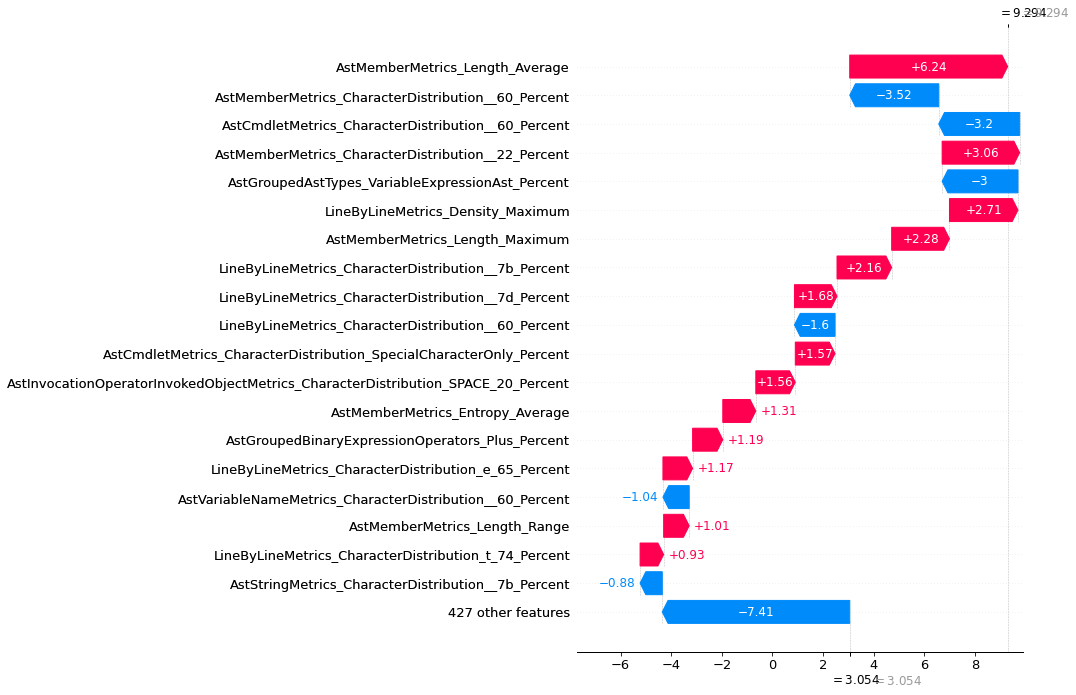

None

SHAP decision plot


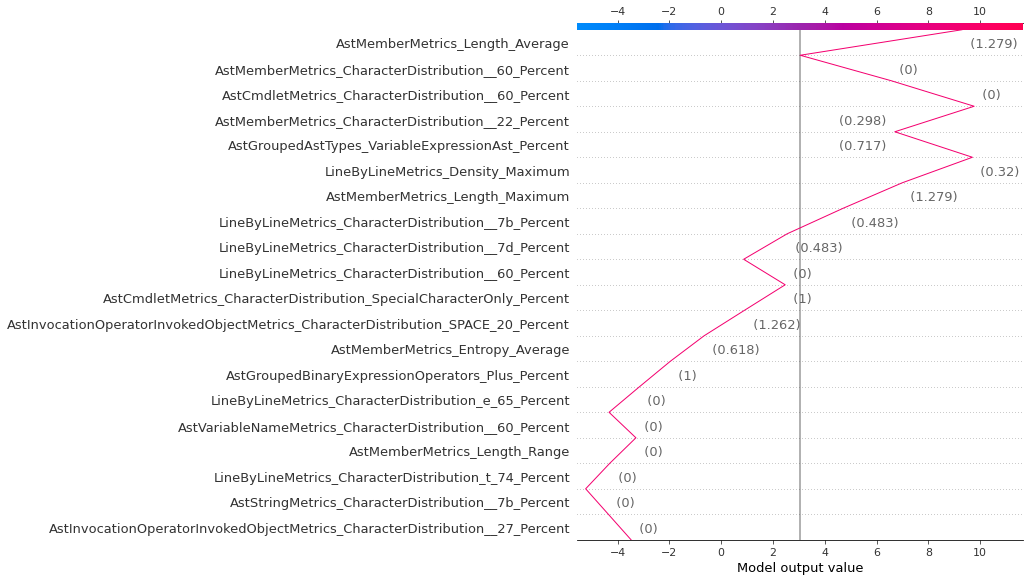

None

In [24]:
# explain the original sample

sample_orig = get_sample('../samples/DBOdemo1.ps1.ast.csv', True)

explain_linear_shap_sample(explainer, pd.DataFrame(scaler.transform(sample_orig), columns=sample_orig.columns))

Modified script against local model:
Local Model Predicted Label   : 0
Local Model Predicted Proba   : [0.99985727 0.00014273]

Modified script against target model:
Target Model Predicted Label  : 0

SHAP waterfall plot


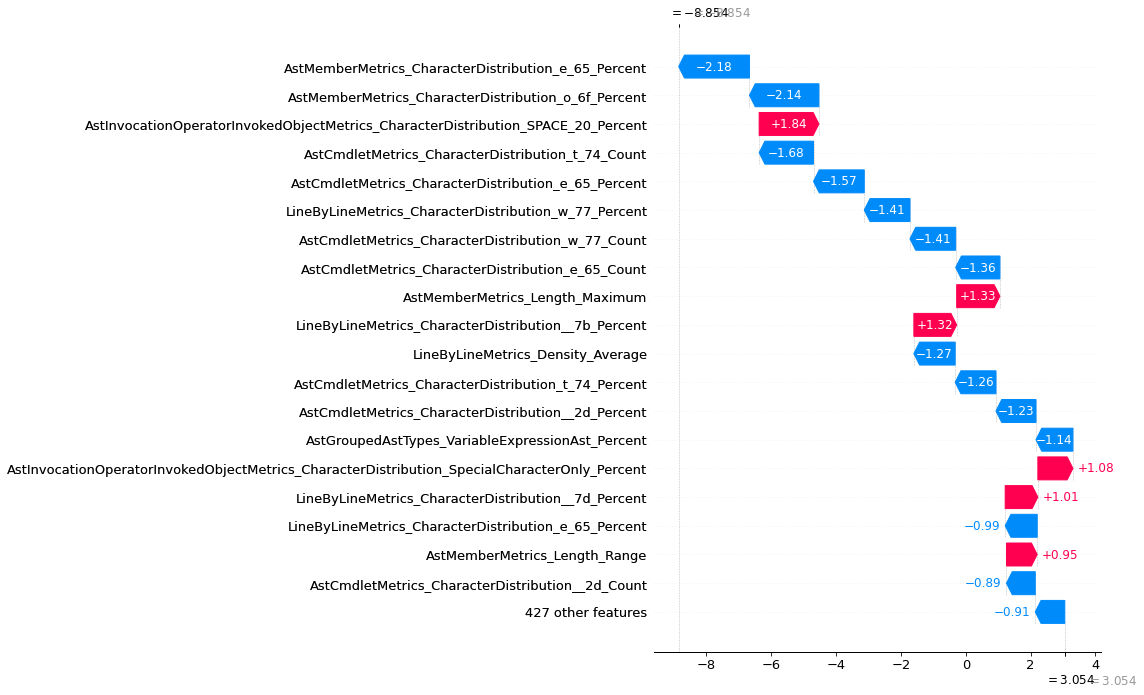

None

SHAP decision plot


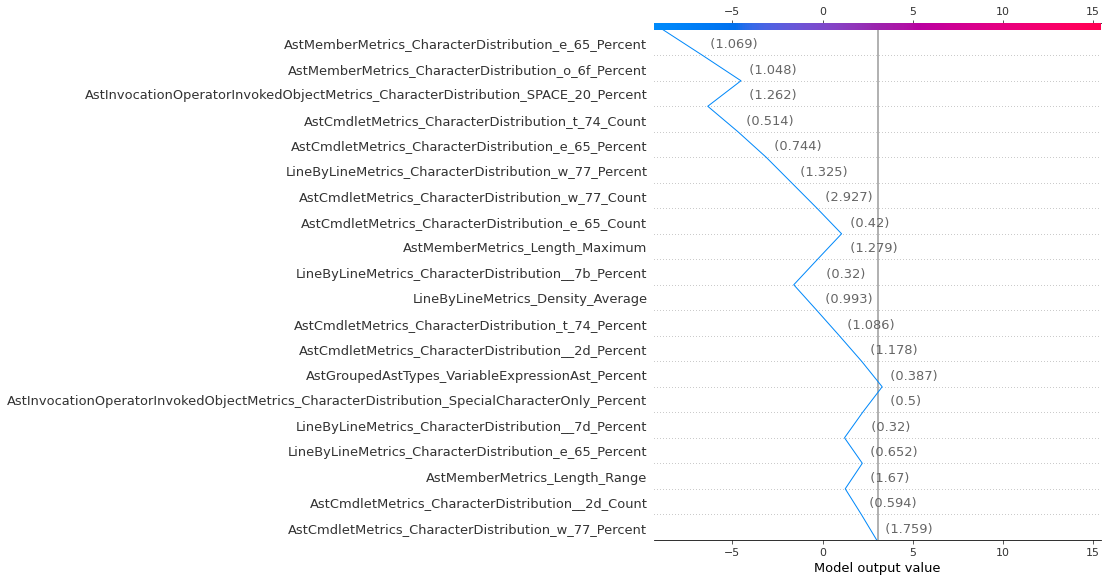

None

In [25]:
# explain the second modified sample

sample_adv = get_sample('../samples/DBOdemo1_model1_second_attempt.ps1.ast.csv', True)

print("Modified script against local model:")
local_model_helper('../samples/DBOdemo1_model1_second_attempt.ps1.ast.csv', lr_model1)

print("Modified script against target model:")
target_model_helper('../samples/DBOdemo1_model1_second_attempt.ps1.ast.csv', 1)

print()

explain_linear_shap_sample(explainer, pd.DataFrame(scaler.transform(sample_adv), columns=sample_adv.columns))

This took a lot of work! Not as much as the white box tree ensemble, but definitely a lot more than having the white box Logistic Regression model.

# Targeting Model2

In [27]:
# let's see how some common attacks transfer
model2_results = fit_art_models(2, X_train_model2, X_test_model2, y_train_model2, y_test_model2)

Fitting: lr
Fitting: nb
Fitting: svc
Fitting: rf
Fitting: xgb
Fitting: nn

Generating adversarial samples for local model 'lr' using HSJ


HopSkipJump:   0%|          | 0/600 [00:00<?, ?it/s]

lr accuracy on real test data                  : 0.9917
lr accuracy on adversarial data                : 0.5000
Target model accuracy on lr adversarial data   : 0.5367
Total local misclassified samples for lr       : 300
Attack Transferability from lr to target       : 0.0733
Attacks transferred from lr to target          : 22

Generating adversarial samples for local model 'nb' using HSJ


HopSkipJump:   0%|          | 0/600 [00:00<?, ?it/s]

nb accuracy on real test data                  : 0.9800
nb accuracy on adversarial data                : 0.5000
Target model accuracy on nb adversarial data   : 0.5150
Total local misclassified samples for nb       : 300
Attack Transferability from nb to target       : 0.0300
Attacks transferred from nb to target          : 9

Generating adversarial samples for local model 'svc' using HSJ


HopSkipJump:   0%|          | 0/600 [00:00<?, ?it/s]

svc accuracy on real test data                  : 0.9917
svc accuracy on adversarial data                : 0.5000
Target model accuracy on svc adversarial data   : 0.5367
Total local misclassified samples for svc       : 300
Attack Transferability from svc to target       : 0.0733
Attacks transferred from svc to target          : 22

Generating adversarial samples for local model 'rf' using HSJ


HopSkipJump:   0%|          | 0/600 [00:00<?, ?it/s]

rf accuracy on real test data                  : 0.9933
rf accuracy on adversarial data                : 0.5000
Target model accuracy on rf adversarial data   : 0.5000
Total local misclassified samples for rf       : 300
Attack Transferability from rf to target       : 0.0000
Attacks transferred from rf to target          : 0

Generating adversarial samples for local model 'xgb' using HSJ


HopSkipJump:   0%|          | 0/600 [00:00<?, ?it/s]

xgb accuracy on real test data                  : 0.9933
xgb accuracy on adversarial data                : 0.5000
Target model accuracy on xgb adversarial data   : 0.5083
Total local misclassified samples for xgb       : 300
Attack Transferability from xgb to target       : 0.0167
Attacks transferred from xgb to target          : 5

Generating adversarial samples for local model 'nn' using FGM


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


nn accuracy on real test data                  : 0.9917
nn accuracy on adversarial data                : 0.9483
Target model accuracy on nn adversarial data   : 0.9800
Total local misclassified samples for nn       : 31
Attack Transferability from nn to target       : 0.9355
Attacks transferred from nn to target          : 29


In [28]:
display_model_results(model2_results)


Model      Local Model Acc (test)    Local Model Acc (adv)    Target Model Acc (adv)    Attacks Transferred to Target    Attack Transferability
-------  ------------------------  -----------------------  ------------------------  -------------------------------  ------------------------
lr                       0.991667                 0.5                       0.536667                               22                 0.0733333
nb                       0.98                     0.5                       0.515                                   9                 0.03
svc                      0.991667                 0.5                       0.536667                               22                 0.0733333
rf                       0.993333                 0.5                       0.5                                     0                 0
xgb                      0.993333                 0.5                       0.508333                                5                 0.0166667
nn  

In [29]:
# display the top "Normal" and "Obfuscated" features for the local Logistic Regression\
lr_model2 = model2_results["lr"][0].best_estimator_

display_lr_features(lr_model2)

Top 'Normal' Features:
---------------------------------------------------------  --------
AstVariableNameMetrics_CharacterDistribution_e_65_Percent  -2.35535
AstCmdletMetrics_CharacterDistribution_e_65_Percent        -1.88308
AstMemberMetrics_CharacterDistribution_e_65_Percent        -1.71891
AstCmdletMetrics_CharacterDistribution_t_74_Percent        -1.66188
AstGroupedAstTypes_AssignmentStatementAst_Percent          -1.37651
LineByLineMetrics_CharacterDistribution_e_65_Percent       -1.34213
AstCommentMetrics_UpperAlphaPercent_Maximum                -1.33738
AstMemberMetrics_CharacterDistribution_t_74_Percent        -1.30392
AstCmdletMetrics_Entropy_Maximum                           -1.23734
AstGroupedAstTypes_CommandExpressionAst_Percent            -1.12571
---------------------------------------------------------  --------

Top 'Obfuscated' Features:
-------------------------------------------------------------------------  -------
AstVariableNameMetrics_CharacterDistribution_Speci

In [30]:
sample = X_test_model2.iloc[0]

print(f"Local LR Initial Predicted value: {lr_model2.predict(sample.to_numpy().reshape(1, -1))[0]}")
# ~30-50 or so is where the decision boundary crosses for the local Logistic Regression model
sample.at["AstCmdletMetrics_CharacterDistribution__60_Percent"] = 47
print(f"Local LR New Predicted Value    : {lr_model2.predict(sample.to_numpy().reshape(1, -1))[0]}")

sample = X_test_model2.iloc[0]
print(f"Target Initial Predicted value  : {target_model_predict(2, sample.to_numpy().reshape(1, -1))[0]}")
# No matter what value we set below, the decision boundary does not change
#    This implies that the model is very likely not linear, so it's likely a decision tree or a Neural Network.
sample.at["AstCmdletMetrics_CharacterDistribution__60_Percent"] = 10000000000000
print(f"Target   New Predicted Value    : {target_model_predict(2, sample.to_numpy().reshape(1, -1))[0]}")

Local LR Initial Predicted value: 0
Local LR New Predicted Value    : 1
Target Initial Predicted value  : 0
Target   New Predicted Value    : 0


No matter what we set the `AstCmdletMetrics_CharacterDistribution__60_Percent` to, we can't change the value of the target, so the target model is likely not linear.

We'll revisit attacking this model in the final section.

# Targeting Model3

In [33]:
# let's see how some common attacks transfer
model3_results = fit_art_models(3, X_train_model3, X_test_model3, y_train_model3, y_test_model3)

Fitting: lr
Fitting: nb
Fitting: svc
Fitting: rf
Fitting: xgb
Fitting: nn

Generating adversarial samples for local model 'lr' using HSJ


HopSkipJump:   0%|          | 0/600 [00:00<?, ?it/s]

lr accuracy on real test data                  : 0.9883
lr accuracy on adversarial data                : 0.3350


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Target model accuracy on lr adversarial data   : 0.6783
Total local misclassified samples for lr       : 399
Attack Transferability from lr to target       : 0.5163
Attacks transferred from lr to target          : 206

Generating adversarial samples for local model 'nb' using HSJ


HopSkipJump:   0%|          | 0/600 [00:00<?, ?it/s]

nb accuracy on real test data                  : 0.9750
nb accuracy on adversarial data                : 0.5067
Target model accuracy on nb adversarial data   : 0.5250
Total local misclassified samples for nb       : 296
Attack Transferability from nb to target       : 0.0372
Attacks transferred from nb to target          : 11

Generating adversarial samples for local model 'svc' using HSJ


HopSkipJump:   0%|          | 0/600 [00:00<?, ?it/s]

svc accuracy on real test data                  : 0.9850
svc accuracy on adversarial data                : 0.5067
Target model accuracy on svc adversarial data   : 0.6350
Total local misclassified samples for svc       : 296
Attack Transferability from svc to target       : 0.2601
Attacks transferred from svc to target          : 77

Generating adversarial samples for local model 'rf' using HSJ


HopSkipJump:   0%|          | 0/600 [00:00<?, ?it/s]

rf accuracy on real test data                  : 0.9900
rf accuracy on adversarial data                : 0.5067
Target model accuracy on rf adversarial data   : 0.7117
Total local misclassified samples for rf       : 296
Attack Transferability from rf to target       : 0.4155
Attacks transferred from rf to target          : 123

Generating adversarial samples for local model 'xgb' using HSJ


HopSkipJump:   0%|          | 0/600 [00:00<?, ?it/s]

xgb accuracy on real test data                  : 0.9883
xgb accuracy on adversarial data                : 0.5067
Target model accuracy on xgb adversarial data   : 0.8467
Total local misclassified samples for xgb       : 296
Attack Transferability from xgb to target       : 0.6926
Attacks transferred from xgb to target          : 205

Generating adversarial samples for local model 'nn' using FGM


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


nn accuracy on real test data                  : 0.9833
nn accuracy on adversarial data                : 0.9417
Target model accuracy on nn adversarial data   : 0.9867
Total local misclassified samples for nn       : 35
Attack Transferability from nn to target       : 0.7714
Attacks transferred from nn to target          : 27


In [34]:
display_model_results(model3_results)


Model      Local Model Acc (test)    Local Model Acc (adv)    Target Model Acc (adv)    Attacks Transferred to Target    Attack Transferability
-------  ------------------------  -----------------------  ------------------------  -------------------------------  ------------------------
lr                       0.988333                 0.335                     0.678333                              206                 0.516291
nb                       0.975                    0.506667                  0.525                                  11                 0.0371622
svc                      0.985                    0.506667                  0.635                                  77                 0.260135
rf                       0.99                     0.506667                  0.711667                              123                 0.415541
xgb                      0.988333                 0.506667                  0.846667                              205                 0.69

In [35]:
# display the top "Normal" and "Obfuscated" features for the local Logistic Regression\
lr_model3 = model3_results["lr"][0].best_estimator_

display_lr_features(lr_model3)

Top 'Normal' Features:
----------------------------------------------------  --------
AstCmdletMetrics_CharacterDistribution_t_74_Percent   -2.0521
AstCmdletMetrics_CharacterDistribution_e_65_Percent   -1.78744
LineByLineMetrics_CharacterDistribution__22_Percent"  -1.73913
AstGroupedAstTypes_StatementBlockAst_Percent          -1.47221
AstGroupedAstTypes_AssignmentStatementAst_Percent     -1.39132
AstMemberMetrics_CharacterDistribution_e_65_Percent   -1.34108
AstCommentMetrics_UpperAlphaPercent_Maximum           -1.24063
AstCmdletMetrics_CharacterDistribution_w_77_Percent   -1.19649
LineByLineMetrics_Density_Average                     -1.18089
AstGroupedAstTypes_CommandExpressionAst_Percent       -1.15009
----------------------------------------------------  --------

Top 'Obfuscated' Features:
-------------------------------------------------------------------------  -------
AstVariableNameMetrics_CharacterDistribution_`_60_Percent                  1.80858
AstMemberMetrics_CharacterDi

In [36]:
sample = X_test_model3.iloc[0]

print(f"Local LR Initial Predicted value: {lr_model3.predict(sample.to_numpy().reshape(1, -1))[0]}")
# ~30-50 or so is where the decision boundary crosses for the local Logistic Regression model
sample.at["AstCmdletMetrics_CharacterDistribution__60_Percent"] = 40
print(f"Local LR New Predicted Value    : {lr_model3.predict(sample.to_numpy().reshape(1, -1))[0]}")

print(f"Target Initial Predicted value  : {target_model_predict(3, sample.to_numpy().reshape(1, -1))[0]}")
# No matter what value we set below, the decision boundary does not change
#    This implies that the model is very likely not linear, so it's likely a decision tree or a Neural Network.
sample.at["AstCmdletMetrics_CharacterDistribution__60_Percent"] = 10000000000000
print(f"Target   New Predicted Value    : {target_model_predict(3, sample.to_numpy().reshape(1, -1))[0]}")

Local LR Initial Predicted value: 0
Local LR New Predicted Value    : 1
Target Initial Predicted value  : 1
Target   New Predicted Value    : 1


No matter what we set the `AstCmdletMetrics_CharacterDistribution__60_Percent` to, we can't change the value of the target, so the target model is likely not linear.

Interestingly, the model that had the highest transferability AND the highest number of transferred attacks was the Logistic Regression (even though we know the actual target is a Neural Network).